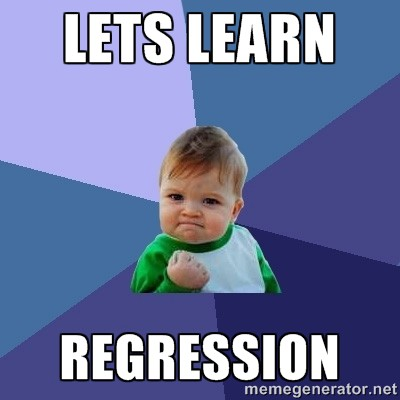

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['figure.dpi'] = 200 #high resolution


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import optuna
from math import sqrt

In [ ]:
#Let's read data
train=pd.read_csv("../input/tabular-playground-series-jan-2021/train.csv")
test=pd.read_csv("../input/tabular-playground-series-jan-2021/test.csv")
sub=pd.read_csv("../input/tabular-playground-series-jan-2021/sample_submission.csv")

In [ ]:
print("Shape of train data:",train.shape)
print("Number of columns in train data:",train.shape[1])
print("Number of rows in train data:",train.shape[0])
train.head()

1. In train data we have 16 columns in which one is target column.
2. All the columns except id are in continous manner.
3. We have all 14 columns which we going to analyze further but we not have their proper names.

In [ ]:
print("Shape of test data:",test.shape)
print("Number of columns in test data:",test.shape[1])
print("Number of rows in test data:",test.shape[0])
test.head()

1. This our test data so obvious we not have any target columns.
2. Here also all the columns are continous data. 

In [ ]:
print("Shape of sub data:",sub.shape)
print("Number of columns in sub data:",sub.shape[1])
print("Number of rows in sub data:",sub.shape[0])
sub.head()

1. This is our submission data after complete our modeling task our submission file should be look similar file as above which having two columns one is id and other is target. 

**Let's start the Work**
1. So let me gives you idea what I am going to do in this notebook below.
* **Step1**: We do Exploratory data analysis for checking null values,relation between the columns and how the columns behave with target column with giving           brief idea about statistical analysis.
* **Step2**: Whatever we do analysis next step we present that analysis with help of some cool grpahs so we can unserstand better.
* **Step3**: During this we also check correlation matrix and if some outliers are there we try to remove in case if we use model except trees model,Outliers           can impact our model.
* **Step4**: We will come up with feature enginerring in this step.
* **Step5**: We developed one basline model.
   

In [ ]:
train.info()

1. There is no missing values in our data set.RELAX!

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(22, 10))
sns.distplot(train['target'],color="darkred",kde=True,bins=120,label='target',ax=ax[0])
sns.boxplot(train['target'],color="darkred",ax=ax[1])
plt.legend();
plt.show()

In [ ]:
train['target'].describe()
print(round(train['target'].median(),1))
train = train[train['target'] != 0].reset_index(drop=True)

1. Our target is kind of bimodal in nature.
2. Target column has one oulier that is 0.
3. We can break bimodal distribution target column to univariate at target median which is near about 8
Bimodal: A probability distribution with two different modes, which may also be referred to as a bimodal distribution.

In [ ]:
#let we analyze our all the features and see they have bimdal nature or unimodal nature
#Feature Analysis
features=['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7','cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']
fig, ax = plt.subplots(5, 3,figsize=(14, 24))
for i,col in enumerate(features):
    plt.subplot(5,3,i+1)
    sns.distplot(train.loc[:,col], kde =True,color="darkred")
fig.tight_layout(pad=1.0)

1. All the features are follow mulimodal distribution having more than two peaks,and already we know our target feature also follow bimodal distribution.

In [ ]:

features=['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7','cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']
fig, ax = plt.subplots(5, 3,figsize=(14, 24))
for i,col in enumerate(features):
    plt.subplot(5,3,i+1)
    sns.distplot(test.loc[:,col], kde =True,color="darkred")
fig.tight_layout(pad=1.0)

1. Test data also contains multimodal distribution features

# Features VS target Distribution:
Now we are going to see how all the 14 features are behaves with respect to target 

In [ ]:
for i in range(1,15):
    sns.jointplot(x='cont'+str(i),y='target',data=train,kind='reg',color='crimson')

In [ ]:
%%time
train_features=train.drop(['id'],axis=1)
corr=train_features.corr()

In [ ]:
#sns.set_theme(style="white")
corr=train_features.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

1. From all the above 14 continous features no one is highly correlated with target feature.
2. Multicollinearity is exist in this dataset.

# Let's Do Modeling:
Still we not do any kind of feature engineering.First we try without feature enginerring and check performance of model

In [ ]:
X=train.drop(['id','target'],axis=1)
y=train['target']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
import warnings
warnings.simplefilter('ignore')

In [ ]:
def rmse_score(yreal, yhat):
    return sqrt(mean_squared_error(yreal, yhat))    

# Linear Regression with Hyperparameter-Tuning:
1. I performed first standardization to make data standard in one scale
2. Used squred_loss(due to OLS) with l2 penality for regularization.
3. Used GridSearch for finding best hyperparameter.

In [ ]:
#standardizing the data
train_std = StandardScaler().fit_transform(X_train)
val_std = StandardScaler().fit_transform(X_val)
    
#hyper-paramater tuning
clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
values = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
hyper_parameter = {"alpha": values}
best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
best_parameter.fit(train_std, y_train)
alpha = best_parameter.best_params_["alpha"]
    
#applying linear regression with best hyper-parameter
clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
clf.fit(train_std, y_train)
train_pred = clf.predict(train_std)
train_RMSE_lr = rmse_score(y_train, train_pred)
val_pred = clf.predict(val_std)
val_RMSE_lr = rmse_score(y_val, val_pred)

print("linear_regression_score:",train_RMSE_lr,val_RMSE_lr)

# XGBoost Regressor with Hyperparameter tuning

In [ ]:
import xgboost as xgb
#hyper-parameter tuning
hyper_parameter = {"max_depth":[ 1,3,2, 4], "n_estimators":[40, 80, 150, 400]}
clf_Xg = xgb.XGBRegressor()
best_parameter = GridSearchCV(clf_Xg, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
best_parameter.fit(X_train, y_train)
estimators = best_parameter.best_params_["n_estimators"]
depth = best_parameter.best_params_["max_depth"]

#applying xgboost regressor with best hyper-parameter
clf_Xg = xgb.XGBRegressor(max_depth = depth, n_estimators = estimators)
clf_Xg.fit(X_train, y_train)
train_pred = clf_Xg.predict(X_train)
train_RMSE_Xg = rmse_score(y_train, train_pred)
val_pred = clf_Xg.predict(X_val)
val_RMSE_Xg = rmse_score(y_val, val_pred)

print("XG_regression_score:",train_RMSE_Xg,val_RMSE_Xg)

In [ ]:
error_table_regressions = pd.DataFrame(columns = ["Model","TrainRMSE","ValRMSE"])

error_table_regressions = error_table_regressions.append(pd.DataFrame([["Linear Regression", train_RMSE_lr,val_RMSE_lr ]], columns = ["Model","TrainRMSE","ValRMSE"]))

error_table_regressions = error_table_regressions.append(pd.DataFrame([["XGBoost Regressor",train_RMSE_Xg,val_RMSE_Xg]], columns = ["Model","TrainRMSE","ValRMSE"]))
error_table_regressions.reset_index(drop = True, inplace = True)

In [ ]:
error_table_regressions

In [ ]:
test=test.drop(['id'],axis=1)
y_test=clf_Xg.predict(test)

In [ ]:
sub = pd.DataFrame({
        "id": sub["id"],
        "target":y_test
    })
sub.to_csv('Xgb_submission.csv', index=False)

# Work in Progress: